<a href="https://colab.research.google.com/github/kooose38/pystan_practice/blob/main/%E3%83%AD%E3%82%B8%E3%82%B9%E3%83%86%E3%82%A3%E3%82%AF%E3%82%B9%E5%9B%9E%E5%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!unzip data.zip 

Archive:  data.zip
replace data/data.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [11]:
!pip install -q pystan 

In [13]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import pystan 
from scipy.stats import mstats 

In [14]:
plt.style.use("ggplot")

In [15]:
df = pd.read_excel("data/dose_response.xlsx")
df.head()

,log10 C,death
0,0.95,0
1,0.94,0
2,0.95,0
3,0.96,0
4,0.99,0


ラベルは２値分類でロジット関数に従う。  
事後分布は*ベルヌーイ分布*に従うと仮定する。  

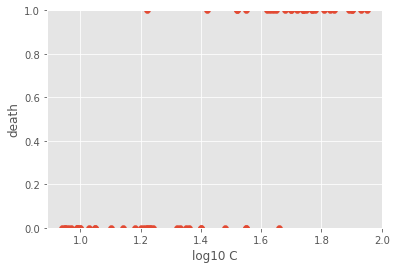

In [16]:
plt.scatter(df["log10 C"], df["death"])
plt.ylim([0.0, 1.0])
plt.xlabel("log10 C")
plt.ylabel("death")
plt.show()

In [19]:
stan_model = """
data {
    int N;
    real X[N];
    int<lower=0, upper=1> Y[N];

}

parameters {
    real a;
    real b;

}

model {
    for (i in 1:N) {
        Y[i] ~ bernoulli_logit(a * X[i] + b);
    }
}

"""

In [20]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fe5e752eced791d08c9b23aa5daf3a2d NOW.


In [22]:
stan_data = {"N": df.shape[0], "X": df["log10 C"], "Y": df["death"]}

In [23]:
fit = sm.sampling(data=stan_data, iter=2000, warmup=500, chains=3, seed=123)

`Rhat`が1.1以下であることを確認.

In [43]:
fit

Inference for Stan model: anon_model_fe5e752eced791d08c9b23aa5daf3a2d.
3 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     13.74    0.14   3.39   8.31  11.28  13.28  15.87  21.55    615    1.0
b    -20.53    0.21   5.12 -32.19 -23.68 -19.84 -16.84 -12.28    620    1.0
lp__ -14.95    0.03   1.06  -17.8 -15.38 -14.62 -14.18 -13.89    926    1.0

Samples were drawn using NUTS at Wed Jan  5 07:55:48 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [25]:
a, b = 13.74, -20.53 

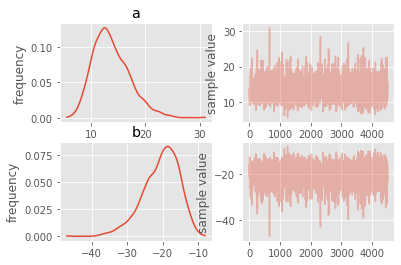

In [26]:
fig = fit.plot()

## 予測信頼区間

In [44]:
ms_a = fit.extract("a")["a"]
ms_b = fit.extract("b")["b"]

In [49]:
x = np.arange(1.0, 2.0, 0.01) # サンプリングするデータ
f = lambda x: 1.0 / (1.0 +  np.exp(-x) )  # ロジット関数
df_b = pd.DataFrame([])

for i in range(x.shape[0]):
    df_b[x[i]] = f(ms_a * x[i] + ms_b)

In [50]:
df_b.head()

,1.00,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.10,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.30,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,...,1.60,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.70,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.80,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.90,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99
0,0.001117,0.001269,0.001441,0.001637,0.001860,0.002113,0.002400,0.002726,0.003097,0.003517,0.003995,0.004537,0.005152,0.005850,0.006641,0.007540,0.008558,0.009713,0.011023,0.012506,0.014186,0.016088,0.018241,0.020675,0.023427,0.026534,0.030042,0.033997,0.038451,0.043464,0.049096,0.055416,0.062496,0.070413,0.079249,0.089086,0.100013,0.112114,0.125476,0.140178,...,0.704560,0.730442,0.754845,0.777712,0.799014,0.818750,0.836943,0.853637,0.868889,0.882770,0.895359,0.906738,0.916995,0.926216,0.934485,0.941886,0.948497,0.954392,0.959641,0.964309,0.968454,0.972132,0.975392,0.978280,0.980835,0.983094,0.985092,0.986856,0.988414,0.989790,0.991003,0.992074,0.993018,0.993850,0.994584,0.995230,0.995800,0.996302,0.996744,0.997133
1,0.009853,0.010830,0.011904,0.013082,0.014376,0.015795,0.017352,0.019059,0.020931,0.022983,0.025230,0.027690,0.030384,0.033330,0.036551,0.040070,0.043913,0.048106,0.052678,0.057657,0.063076,0.068967,0.075363,0.082301,0.089815,0.097942,0.106718,0.116179,0.126360,0.137295,0.149015,0.161548,0.174918,0.189146,0.204244,0.220219,0.237073,0.254794,0.273366,0.292759,...,0.754990,0.772239,0.788613,0.804109,0.818731,0.832488,0.845398,0.857484,0.868771,0.879291,0.889074,0.898157,0.906574,0.914362,0.921557,0.928194,0.934311,0.939939,0.945114,0.949867,0.954228,0.958227,0.961890,0.965243,0.968312,0.971117,0.973681,0.976023,0.978161,0.980112,0.981892,0.983516,0.984996,0.986345,0.987575,0.988695,0.989715,0.990644,0.991489,0.992259
2,0.009061,0.009866,0.010743,0.011696,0.012733,0.013861,0.015086,0.016419,0.017867,0.019440,0.021149,0.023004,0.025018,0.027204,0.029574,0.032144,0.034930,0.037948,0.041215,0.044750,0.048573,0.052705,0.057167,0.061982,0.067174,0.072767,0.078787,0.085258,0.092208,0.099663,0.107649,0.116192,0.125318,0.135051,0.145415,0.156430,0.168115,0.180486,0.193556,0.207333,...,0.614133,0.634300,0.654007,0.673199,0.691828,0.709853,0.727239,0.743960,0.759993,0.775326,0.789950,0.803863,0.817067,0.829571,0.841387,0.852529,0.863015,0.872868,0.882108,0.890761,0.898851,0.906406,0.913450,0.920011,0.926115,0.931787,0.937054,0.941940,0.946467,0.950661,0.954541,0.958130,0.961447,0.964511,0.967340,0.969950,0.972358,0.974577,0.976623,0.978508
3,0.000435,0.000513,0.000605,0.000713,0.000841,0.000992,0.001169,0.001379,0.001626,0.001917,0.002259,0.002663,0.003139,0.003700,0.004361,0.005138,0.006054,0.007131,0.008399,0.009890,0.011643,0.013701,0.016118,0.018953,0.022275,0.026164,0.030711,0.036018,0.042203,0.049396,0.057740,0.067394,0.078527,0.091320,0.105957,0.122624,0.141497,0.162736,0.186471,0.212788,...,0.896115,0.910494,0.923054,0.933980,0.943449,0.951630,0.958680,0.964740,0.969939,0.974392,0.978200,0.981453,0.984228,0.986594,0.988609,0.990324,0.991783,0.993023,0.994077,0.994973,0.995734,0.996380,0.996929,0.997395,0.997790,0.998125,0.998410,0.998651,0.998856,0.999030,0.999177,0.999302,0.999408,0.999498,0.999574,0.999639,0.999694,0.999740,0.999780,0.999813
4,0.000129,0.000157,0.000191,0.000233,0.000283,0.000344,0.000419,0.000510,0.000620,0.000755,0.000918,0.001117,0.001358,0.001652,0.002010,0.002444,0.002972,0.003614,0.004394,0.005342,0.006492,0.007888,0.009581,0.011634,0.014120,0.017128,0.020763,0.025151,0.030436,0.036790,0.044411,0.053521,0.064375,0.077251,0.092447,0.110275,0.131045,0.155045,0.182517,0.213627,...,0.943569,0.953150,0.961172,0.967867,0.973439,0.978067,0.981903,0.985079,0.987704,0.989872,0.991661,0.993137,0.994352,0.995354,0.996178,0.996857,0.997415,0.997875,0.998253,0.998564,0.998819,0.999029,0.999202,0.999344,0.999461,0.999557,0.999636,0.999701,0.999754,0.999798,0.999834,0.999863,0.999888,0.999908,0.999924,0.999938,0

In [51]:
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0) 
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis=0) 
low_y50.shape

(100,)

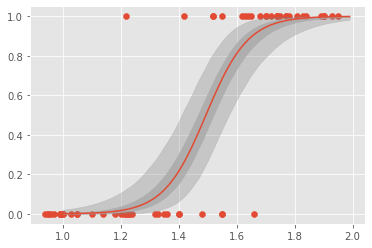

In [55]:
plt.scatter(df["log10 C"], df["death"])
plt.fill_between(x, low_y95, high_y95, alpha=.3, color="gray")
plt.fill_between(x, low_y50, high_y50, alpha=.8, color="darkgray")
plt.plot(x, f(a * x + b))